### Imports

In [1]:
import pandas as pd
import seaborn as sns
import sys
import glob
import pathlib
from oak_cli.utils.logging import logger
from icecream import ic

from oak_cli.evaluation.graph_utils import PALETTE, ROUNDING_PRECISION
from oak_cli.evaluation.addons.flops.graph_utils.keys import (
    RUN_ID_KEY,
    CPU_KEY,
    DISK_LAST_KEY,
    DISK_START_KEY,
    MEMORY_KEY,
    NETWORK_LAST_KEYS,
    NETWORK_START_KEYS,
    STAGE_KEY,
    TIME_START_KEY,
    ACCURACY_KEY,
    LOSS_KEY,
)
from oak_cli.evaluation.addons.flops.graph_utils.main import draw_graph, STAGE_ID_KEY, normalize_df_time_ranges
from oak_cli.evaluation.addons.flops.graph_utils.special_graphs import (
    draw_box_violin_plot_for_each_stage,
    draw_line_graph_with_all_runs,
    draw_trained_model_comparison_graph,
)
from oak_cli.evaluation.addons.flops.main import EvaluationRunFLOpsProjectStage

### Settings

In [2]:
VERBOSE = True

### Data Loading

In [3]:
#csv_dir = get_csv_dir_for_scenario(EvaluationScenario.FLOPS)
csv_dir = pathlib.Path("/home/alex/oakestra-cli/oak_cli/evaluation/addons/flops/csv/monolith_mnist_sklearn_small_without_baseimages")
#csv_dir = pathlib.Path("/home/alex/oakestra-cli/oak_cli/evaluation/addons/flops/csv/monolith_hierarchical_mnist_sklearn_small_without_baseimages")

csv_files = glob.glob(f'{csv_dir}/evaluation_run_*.csv')
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

# Add a numerical stage ID (instead of the string) for future numerical manipulations.
df[STAGE_ID_KEY]  =  df[STAGE_KEY].apply(lambda stage_name: EvaluationRunFLOpsProjectStage(stage_name).get_index())

#trained_model_df = pd.read_csv(TRAINED_MODEL_PERFORMANCE_CSV)
trained_model_df = pd.read_csv(csv_dir / "trained_models.csv")

# NOTE: The CSV "time-since-start" values are very precise, thus they differ (slightly) between Evaluation-Runs.
# This difference leads to issues when trying to plot them in an aggregated way.
# To fix this we cast the floats to ints instead. I.e. we are looking at whole seconds - which is fine for this concrete use-case.
df[[TIME_START_KEY]] = round(df[[TIME_START_KEY]].astype(int) / 60, ROUNDING_PRECISION)

df.set_index(TIME_START_KEY, inplace=True)

normalized_df = normalize_df_time_ranges(df)

singular_run_df = df[df[RUN_ID_KEY] == (df[RUN_ID_KEY].max() // 2)]

### Error Handing & Checking

In [4]:
if not csv_dir.exists():
    logger.error(f"{csv_dir} does not exist yet!")
    sys.exit(1)

### Auxiliary

In [5]:
if VERBOSE:
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)

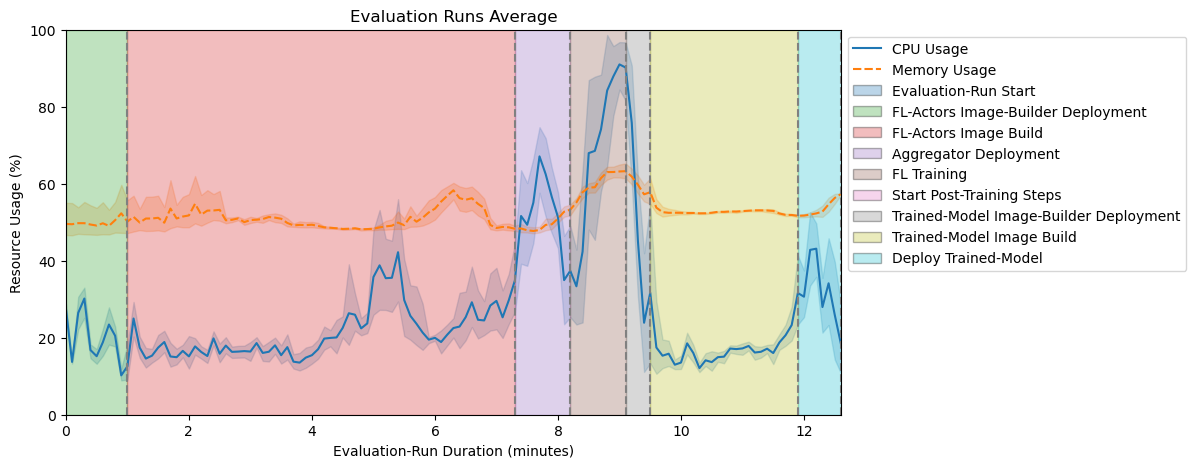

In [8]:
draw_graph(
    title="Evaluation Runs Average",
    data=normalized_df[[CPU_KEY, MEMORY_KEY, STAGE_KEY, RUN_ID_KEY]],
    plot_functions=[
        lambda: sns.lineplot(data=normalized_df[[CPU_KEY, MEMORY_KEY, STAGE_KEY]])
    ],
    use_percentage_limits=True,
    y_label="Resource Usage (%)",
    show_stages=True,
    use_median_stages=True,
)

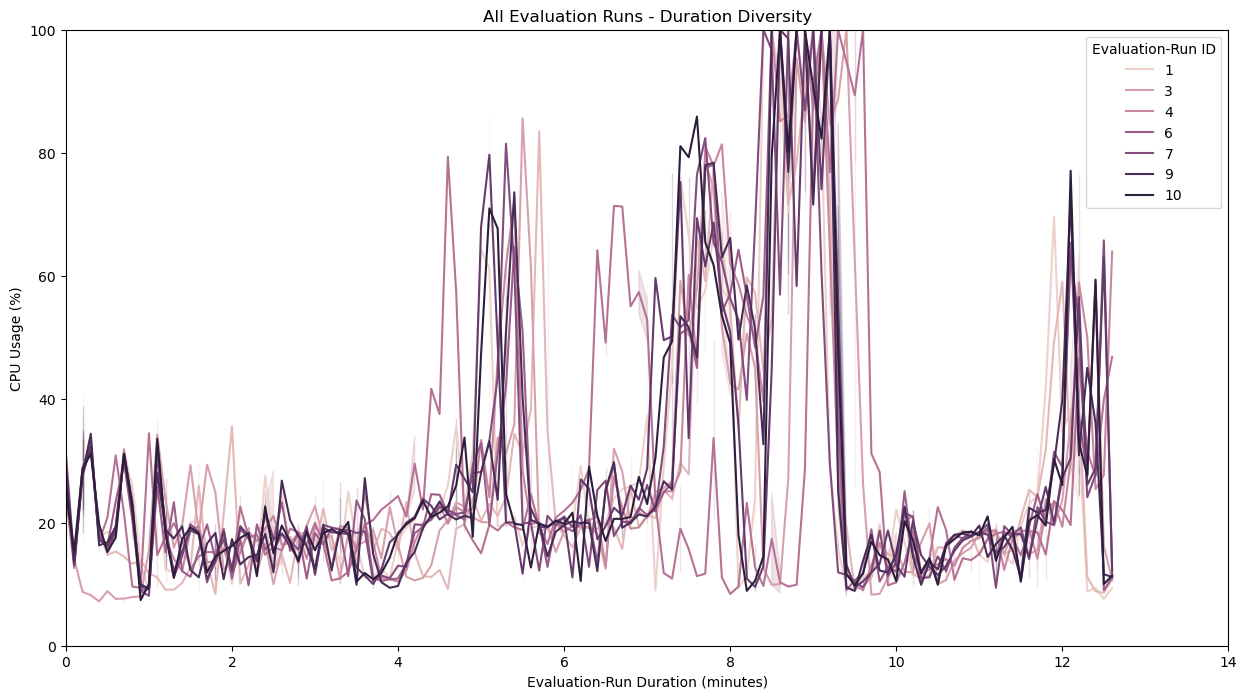

In [10]:
# draw_graph(
#     title="Evaluation Runs Average",
#     data=_df[[CPU_KEY, MEMORY_KEY, STAGE_KEY]],
#     use_percentage_limits=True,
#     y_label="Resource Usage (%)",
#     #show_stages=True,
#     #stages_color_intensity=0.01,
# )

# draw_line_graph_with_all_runs(
#     data=_df,
#     y_label="CPU Usage (%)",
#     key=CPU_KEY,
#     )

from typing import Optional
def _draw_line_graph_with_all_runs(
    data: pd.DataFrame,
    y_label: str,
    key: str,
    title: str = "All Evaluation Runs - Duration Diversity",
    font_size_multiplier: float = 1,
    y_axis_font_size_multiplier: Optional[float] = None,
    x_axis_font_size_multiplier: Optional[float] = None,
) -> None:
    draw_graph(
        title=title,
        y_label=y_label,
        size=(15, 8),
        data=data,
        plot_functions=[
            lambda: sns.lineplot(
                data=data,
                x=TIME_START_KEY,
                y=key,
                hue=RUN_ID_KEY,
            )
        ],
        #use_percentage_limits=True,
        font_size_multiplier=font_size_multiplier,
        y_axis_font_size_multiplier=y_axis_font_size_multiplier,
        x_axis_font_size_multiplier=x_axis_font_size_multiplier,
        x_lim=0,
        y_lim=(0,100),
    )

_draw_line_graph_with_all_runs(
    data=normalized_df,
    y_label="CPU Usage (%)",
    key=CPU_KEY,
    )

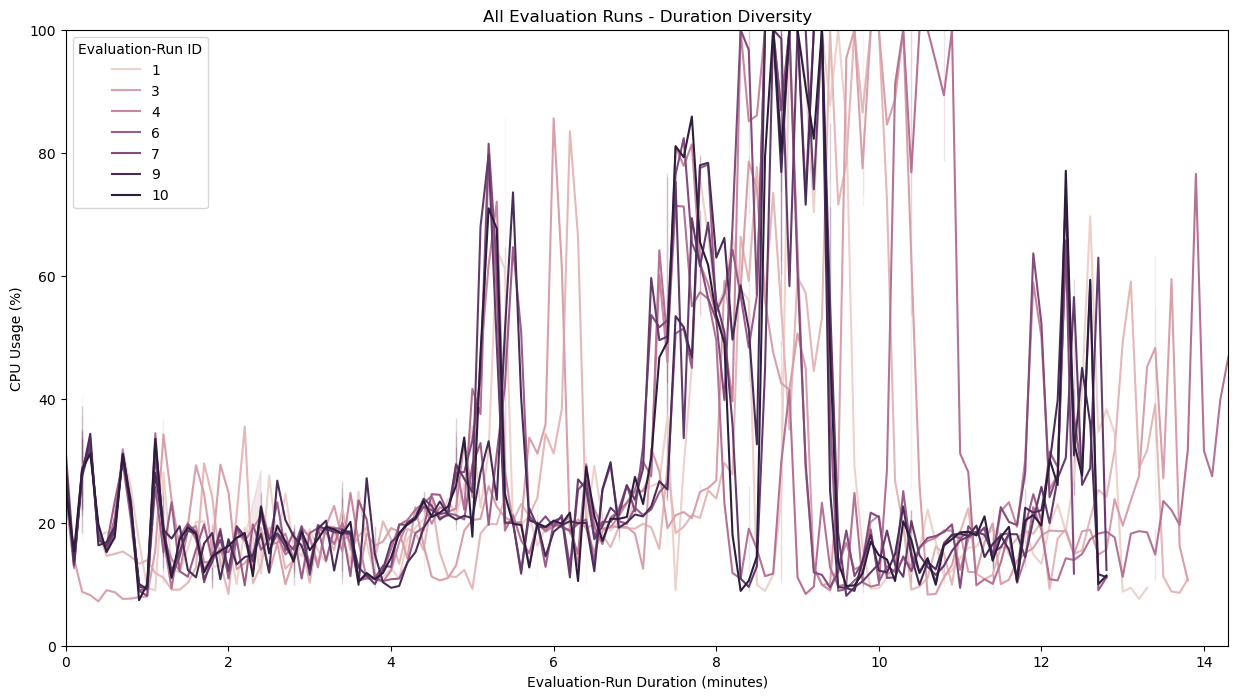

In [ ]:
draw_line_graph_with_all_runs(
    data=df,
    y_label="CPU Usage (%)",
    key=CPU_KEY,
    )

### Common Graph Styling

In [ ]:
sns.set_style("whitegrid")

---

# Graphs Drawing

### CPU & Memory

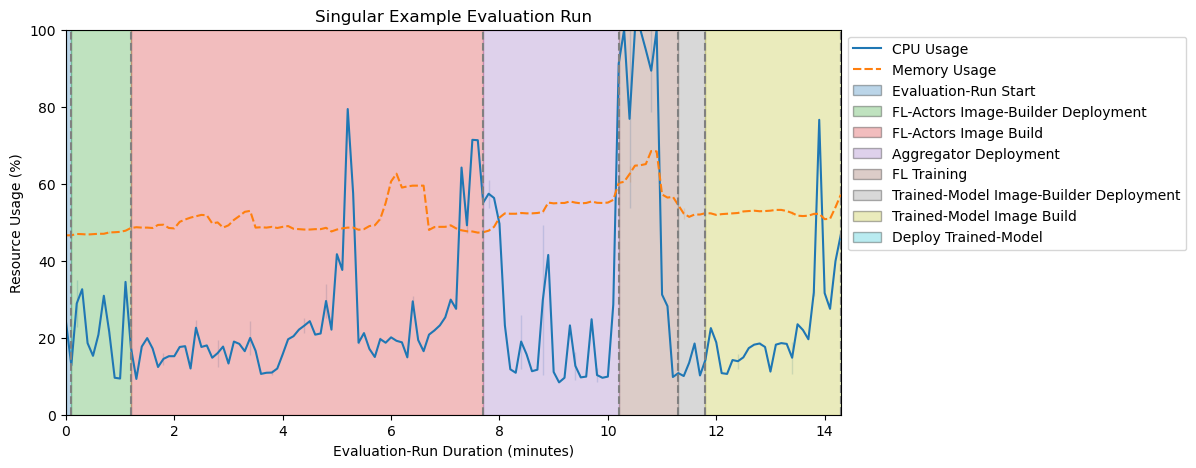

In [ ]:
draw_graph(
    title="Singular Example Evaluation Run",
    data=singular_run_df[[CPU_KEY, MEMORY_KEY, STAGE_KEY]],
    show_stages=True,
    use_percentage_limits=True,
    y_label="Resource Usage (%)",
)

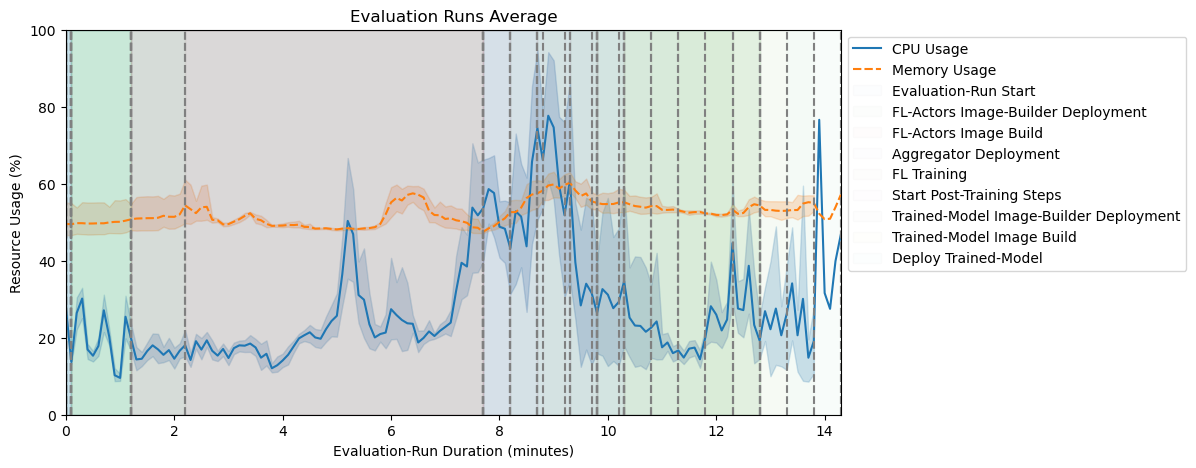

In [ ]:
draw_graph(
    title="Evaluation Runs Average",
    data=df[[CPU_KEY, MEMORY_KEY, STAGE_KEY]],
    use_percentage_limits=True,
    y_label="Resource Usage (%)",
    show_stages=True,
    stages_color_intensity=0.01,
)

<Axes: ylabel='Proportion'>

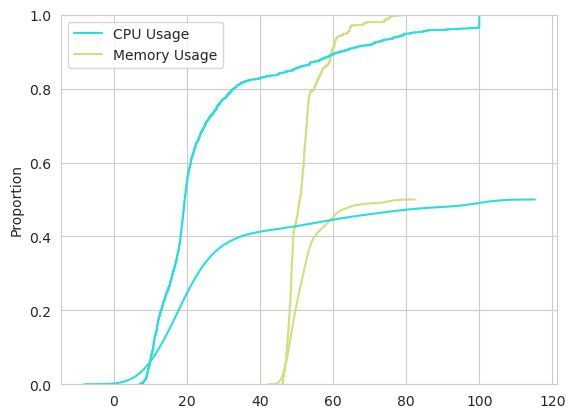

In [ ]:
sns.ecdfplot(
    #x=STAGE_KEY,
    #x=CPU_KEY,
    data=df[[CPU_KEY, MEMORY_KEY]],
    palette=PALETTE,
    #hue=STAGE_KEY,
)
sns.kdeplot(
    #x=STAGE_KEY,
    #x=CPU_KEY,
    data=df[[CPU_KEY, MEMORY_KEY]],
    palette=PALETTE,
    #hue=STAGE_KEY,
    cumulative=True,
)

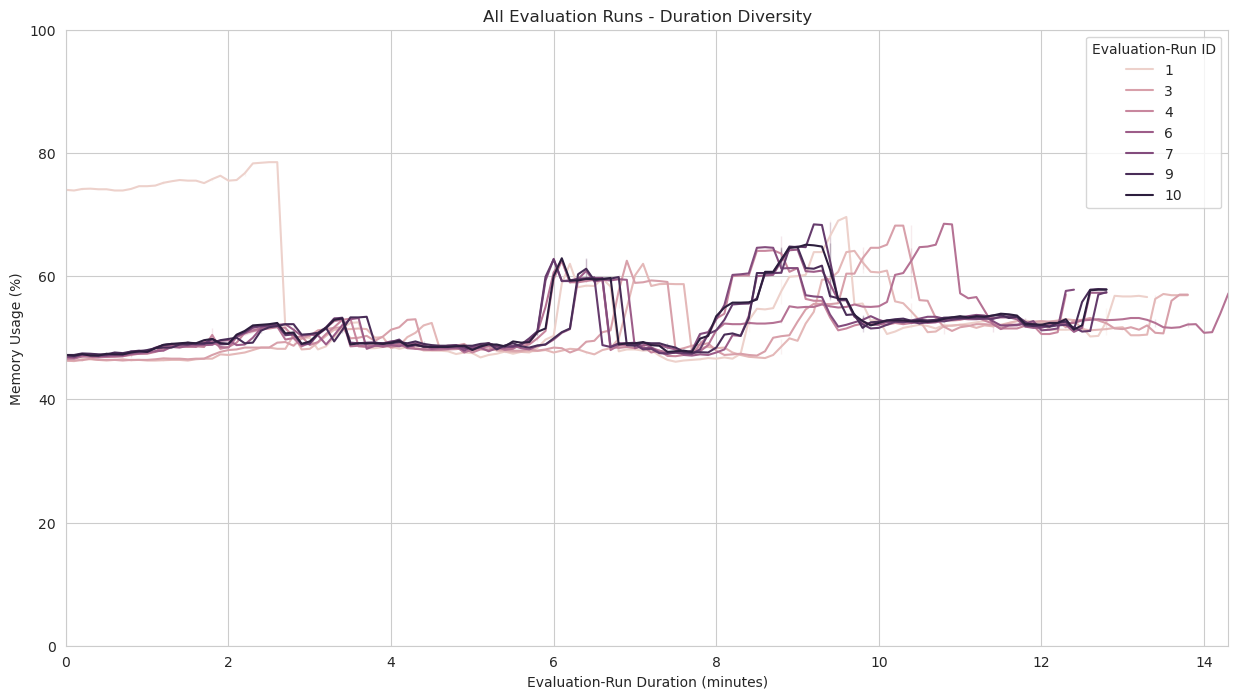

In [ ]:
draw_line_graph_with_all_runs(
    data=df,
    y_label="Memory Usage (%)",
    key=MEMORY_KEY,
    )

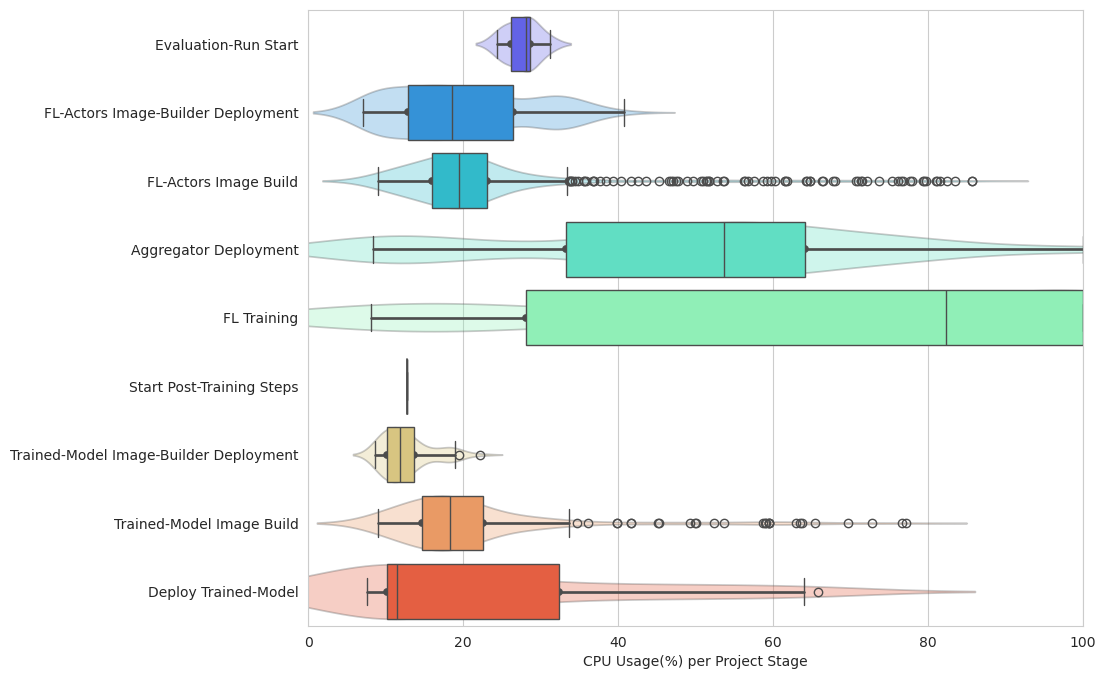

In [ ]:
draw_box_violin_plot_for_each_stage(
    data=df,
    key=CPU_KEY,
    x_label="CPU Usage(%) per Project Stage",
)

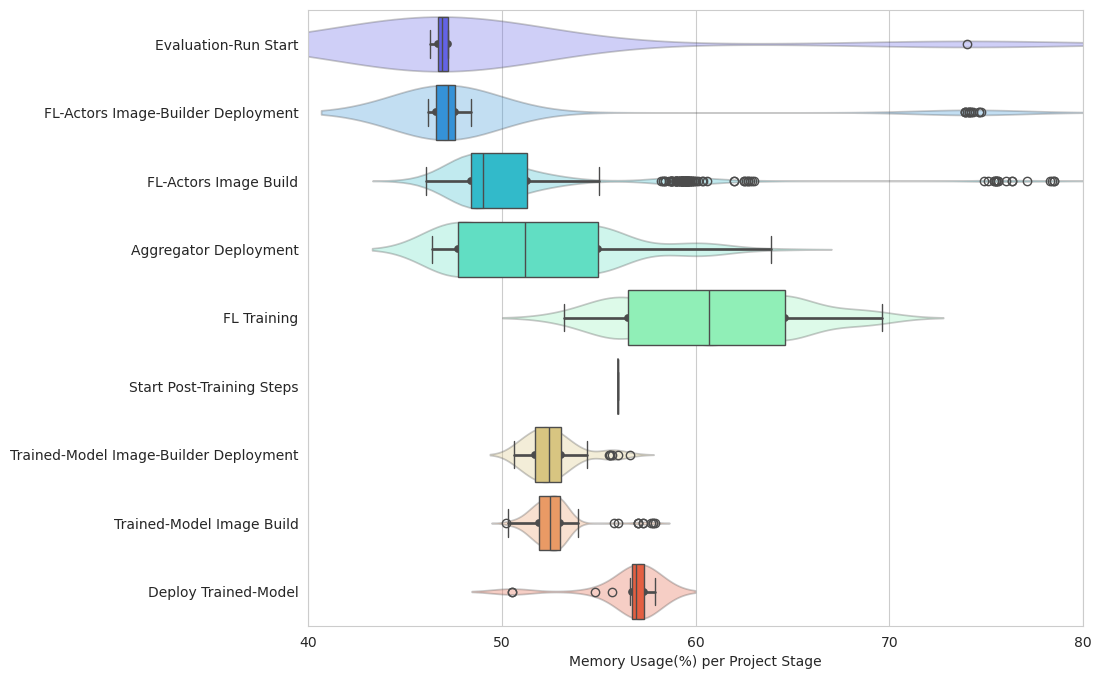

In [ ]:
draw_box_violin_plot_for_each_stage(
    data=df,
    key=MEMORY_KEY,
    x_label="Memory Usage(%) per Project Stage",
    x_lim=(40,80),
)

In [ ]:
# Step 1 & 2: Group by 'experiment_run' and 'stage', then sum 'time'
#grouped = df.groupby([RUN_ID_KEY, STAGE_KEY])[TIME_START_KEY].sum().reset_index()

# _df = df.copy()

# # _df["STAGE ID"]  =  _df[STAGE_KEY].apply(lambda stage_name: EvaluationRunFLOpsProjectStage(stage_name).get_index())
# #_df
# #grouped = _df.groupby(STAGE_ID_KEY)[TIME_START_KEY].sum().reset_index()
# _df.sort_values(by=[RUN_ID_KEY, STAGE_ID_KEY], inplace=True)
# grouped = _df.groupby([RUN_ID_KEY, STAGE_ID_KEY]).size().reset_index(name="count")
# max_count_per_stage = grouped.groupby(STAGE_ID_KEY)['count'].transform(max)
# normalized_counts = grouped['count'] / max_count_per_stage * 100
# type(normalized_counts)
# # average_percentages = normalized_counts.groupby(STAGE_ID_KEY).mean().round(ROUNDING_PRECISION)
# # average_percentages



NameError: name 'STAGE_DURATIONS_KEY' is not defined

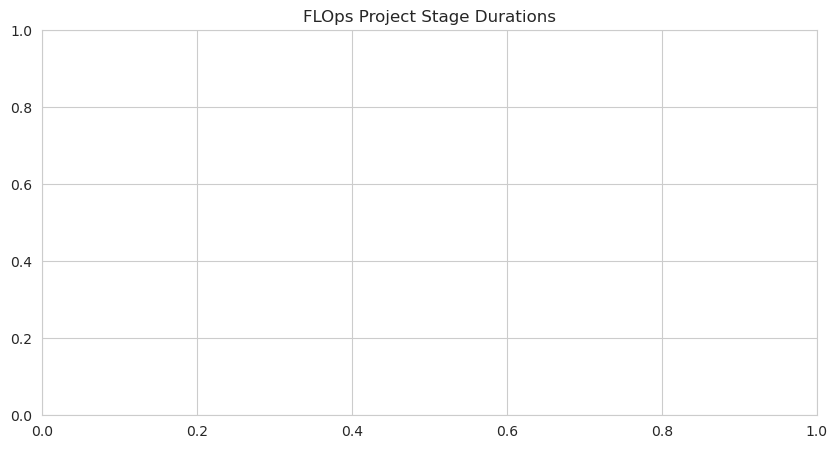

In [ ]:
draw_graph(
    data=stage_durations_df,
    plot_functions=[
        lambda: sns.barplot(
            data=stage_durations_df,
            x=STAGE_DURATIONS_KEY,
            y=STAGE_KEY,
            palette=PALETTE,
            hue=STAGE_KEY,
        )
    ],
    title="FLOps Project Stage Durations",
)


### Disk Space Changes

In [ ]:
_singular_run_df = singular_run_df.copy()
_singular_run_df[[DISK_START_KEY]] = _singular_run_df[[DISK_START_KEY]] / 1024

draw_graph(
    title="Singular Example Evaluation Run",
    data=_singular_run_df[[DISK_START_KEY, STAGE_KEY]],
    y_label="Disk Space Change (GB)",
    x_lim=(0, max(_singular_run_df.index)),
    y_lim=0,
    show_stages=True,
    
)

In [ ]:
_df = df.copy()
_df[[DISK_START_KEY]] = _df[[DISK_START_KEY]] / 1024

draw_graph(
    title="Evaluation Runs Average",
    data=_df[[DISK_START_KEY, STAGE_KEY]],
    y_label="Disk Space Change (GB)",
    x_lim=(0, max(_df.index)),
    #show_stages=True,
    #stages_color_intensity=0.01,
)

In [ ]:

max_y = singular_run_df[DISK_LAST_KEY].max()
draw_graph(
    title="Singular Example Evaluation Run",
    data=singular_run_df[[DISK_LAST_KEY, STAGE_KEY]],
    y_label="Disk Space Change Between Measurements (MB)",
    x_lim=(0, max(singular_run_df.index)),
    show_stages=True,
    stages_color_height=max_y,
    y_lim=(0, max_y)
)

In [ ]:
max_y = df[DISK_LAST_KEY].max()
draw_graph(
    title="Evaluation Runs Average",
    data=df[[DISK_LAST_KEY, STAGE_KEY]],
    y_label="Disk Space Change Between Measurements (MB)",
    x_lim=(0, max(df.index)),
    #y_lim=(0, max_y),
    y_lim=(0, 2000),
    #show_stages=True,
    #stages_color_intensity=0.01,
)

### Network

In [ ]:
_singular_run_df = singular_run_df.copy()
_singular_run_df[NETWORK_START_KEYS] = _singular_run_df[NETWORK_START_KEYS] / 1024

draw_graph(
    title="Evaluation Runs Average",
    data=_singular_run_df[NETWORK_START_KEYS + [STAGE_KEY]],
    y_label="Network Change (GB)",
    x_lim=(0, max(_singular_run_df.index)),
    show_stages=True,
)

In [ ]:
_df = df.copy()
_df[NETWORK_START_KEYS] = _df[NETWORK_START_KEYS] / 1024

draw_graph(
    title="Evaluation Runs Average",
    data=_df[NETWORK_START_KEYS + [STAGE_KEY]],
    y_label="Network Change (GB)",
    x_lim=(0, max(_df.index)),
    #show_stages=True,
    #stages_color_intensity=0.01,
)

In [ ]:
draw_graph(
    title="Evaluation Runs Average",
    data=singular_run_df[NETWORK_LAST_KEYS + [STAGE_KEY]],
    y_label="Network Changes Between Measurements (MB)",
    x_lim=(0, max(singular_run_df.index)),
    y_lim=(0, 1000),
    show_stages=True,
    stages_color_height=1000
)

In [ ]:
draw_graph(
    title="Evaluation Runs Average",
    data=df[NETWORK_LAST_KEYS + [STAGE_KEY]],
    y_label="Network Changes Between Measurements (MB)",
    x_lim=(0, max(df.index)),
    y_lim=(0, 1000),
    #show_stages=True,
    #stages_color_intensity=0.01,
)

### Trained Models

In [ ]:
draw_trained_model_comparison_graph(
    data=trained_model_df,
    key=ACCURACY_KEY,
    y_label="Accuracy (%)"
)

In [ ]:
draw_trained_model_comparison_graph(
    data=trained_model_df,
    key=LOSS_KEY,
    y_label="Loss (%)"
)